In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import zipfile
import os, glob, itertools
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch
from torchvision.models import vgg19
from torchvision.utils import save_image

In [ ]:
# with zipfile.ZipFile("/content/drive/My Drive/SRGAN/DIV2K_train_LR_unknown-20230310T021856Z-001.zip", 'r') as zObject:
#     zObject.extractall(path="/content/drive/My Drive/SRGAN/")

In [ ]:
# # import requests, io
# r = requests.get("http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_unknown_X2.zip")
# z = zipfile.ZipFile(io.BytesIO(r.content))
# z.extractall("/content/drive/My Drive/SRGAN/")

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, paths, lr_shape, hr_shape):
        self.lr_height, self.lr_width = lr_shape
        self.hr_height, self.hr_width = hr_shape
        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                transforms.Resize((self.lr_height, self.lr_width), Image.BICUBIC),
                transforms.ToTensor(),
                # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                transforms.Resize((self.hr_height, self.hr_width), Image.BICUBIC),
                transforms.ToTensor(),
                # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
        self.paths = paths

    def __getitem__(self, index):
        path = self.paths[index % len(self.paths)]
        img_hr = Image.open(path)
        img_lr = Image.open("/content/drive/My Drive/SRGAN/train/DIV2K_train_LR_unknown/X2/" + path.split('/')[-1].split('.')[0] + "x2.png")
        # five_crop_lr = transforms.FiveCrop((self.lr_height, self.lr_width))
        # five_crop_hr = transforms.FiveCrop((self.hr_height, self.hr_width))
        # imgs_lr = five_crop_lr(img_lr)
        # imgs_hr = five_crop_hr(img_hr)
        # img_idx = np.random.randint(5)
        img_lr = self.lr_transform(img_lr)
        img_hr = self.hr_transform(img_hr)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.paths)

In [ ]:
class Generator(torch.nn.Module):
    def __init__(self, in_channels=3, out_channels=3, n_residual_blocks=16,
                 n_residual_features=64):
        super(Generator, self).__init__()

        self.conv1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels, out_channels=n_residual_features,
                            kernel_size=9, stride=1, padding=4),
            torch.nn.PReLU(),
        )

        class ResidualBlock(torch.nn.Module):
            def __init__(self, n_features=64):
                super(ResidualBlock, self).__init__()

                self.block = torch.nn.Sequential(
                    torch.nn.Conv2d(in_channels=n_features, out_channels=n_features,
                                    kernel_size=3, stride=1, padding=1),
                    torch.nn.BatchNorm2d(num_features=n_features),
                    torch.nn.PReLU(),
                    torch.nn.Conv2d(in_channels=n_features, out_channels=n_features,
                                    kernel_size=3, stride=1, padding=1),
                    torch.nn.BatchNorm2d(num_features=n_features),
                )

            def forward(self, x):
                out = torch.add(x, self.block(x))
                return out

        res_blocks = list()
        for _ in range(n_residual_blocks):
            res_blocks.append(ResidualBlock(n_features=n_residual_features))

        self.residual_blocks = torch.nn.Sequential(*res_blocks)

        self.conv2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=n_residual_features, out_channels=n_residual_features,
                            kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(num_features=n_residual_features),
        )

        self.up_sampler = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=n_residual_features, out_channels=n_residual_features*4,
                            kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(num_features=n_residual_features*4),
            torch.nn.PixelShuffle(upscale_factor=2),
            torch.nn.PReLU(),
            # torch.nn.Conv2d(in_channels=n_residual_features, out_channels=n_residual_features*4,
            #                 kernel_size=3, stride=1, padding=1),
            # torch.nn.BatchNorm2d(num_features=n_residual_features*4),
            # torch.nn.PixelShuffle(upscale_factor=2),
            # torch.nn.PReLU(),
        )

        self.conv3 = torch.nn.Conv2d(in_channels=n_residual_features, out_channels=out_channels,
                            kernel_size=9, stride=1, padding=4)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.residual_blocks(x1)
        x3 = torch.add(self.conv2(x2), x1)
        x4 = self.up_sampler(x3)
        x5 = self.conv3(x4)
        out = torch.tanh(x5)

        return out

In [ ]:
class Discriminator(torch.nn.Module):
    def __init__(self, in_channels=3):
        super(Discriminator, self).__init__()

        self.features = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1),
            torch.nn.BatchNorm2d(64),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1),
            torch.nn.BatchNorm2d(128),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1),
            torch.nn.BatchNorm2d(256),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1),
            torch.nn.BatchNorm2d(512),
            torch.nn.LeakyReLU(0.2, True),
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(131072, 1024),
            torch.nn.LeakyReLU(0.2, True),
            torch.nn.Linear(1024, 1),
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = torch.flatten(x1, 1)
        out = self.classifier(x2)

        return out

In [ ]:
# class VGGFeatureMap(torch.nn.Module):
#     def __init__(self):
#         super(VGGFeatureMap, self).__init__()
#         vgg19_model = vgg19(pretrained=True)
#         self.vgg_layer = torch.nn.Sequential(*list(vgg19_model.features.children())[:18])

#     def forward(self, x):
#         return self.vgg_layer(x)

In [ ]:
train_dataset_path = "/content/drive/My Drive/SRGAN/train/DIV2K_train_HR"
train_paths = glob.glob(train_dataset_path + "/*.*")
train_dataset = ImageDataset(train_paths, (270, 480), (540, 960))

In [ ]:
inputs = train_dataset[420]

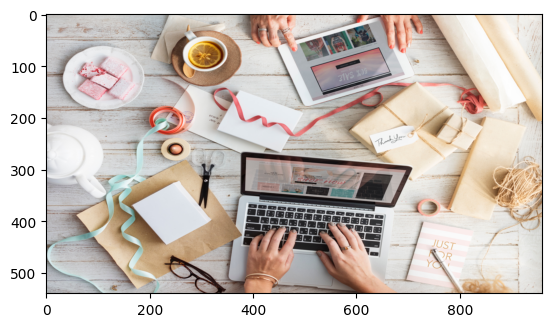

In [ ]:
plt.imshow(inputs["hr"].permute(1, 2, 0))

In [ ]:
save_image(inputs["lr"], '/content/drive/My Drive/SRGAN/Report/LR.png')

In [ ]:
os.makedirs("/content/drive/My Drive/SRGAN/Report")

In [ ]:
if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"
print(dev)
device = torch.device(dev)

cuda:0


In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)
# vgg_fm = VGGFeatureMap().to(device)
generator.load_state_dict(torch.load("/content/drive/My Drive/SRGAN/Checkpoints/generator_current.pth"))
discriminator.load_state_dict(torch.load("/content/drive/My Drive/SRGAN/Checkpoints/discriminator_current.pth"))
# ,map_location ='cpu'

<All keys matched successfully>

In [ ]:
hr_transform = transforms.Compose(
            [
                transforms.Resize((256, 192), Image.BICUBIC),
                transforms.ToTensor(),
                # transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
img_hr = hr_transform(Image.open("/content/drive/My Drive/SRGAN/valid/DIV2K_valid_HR/" + "0880" + ".png"))
save_image(img_hr, '/content/drive/My Drive/SRGAN/pres_gt.png')
# inv_norm = transforms.Normalize((-1,-1,-1),(2,2,2))
# input_lr = torch.unsqueeze(img_lr, dim=0)
# with torch.no_grad():
#     output_hr = generator(input_lr.to(device))
# save_image(inv_norm(output_hr[0]), '/content/drive/My Drive/SRGAN/pres1.png')

In [ ]:
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)

In [ ]:
adversarial_criterion = torch.nn.BCEWithLogitsLoss().to(device)
content_criterion = torch.nn.MSELoss().to(device)

In [ ]:
n_epochs = 120
n_epoch_start = 94
batch_size = 4

In [ ]:
# f = open("/content/drive/My Drive/SRGAN/Checkpoints2/logs.txt", "x")

In [ ]:
for epoch in range(n_epoch_start, n_epochs+1):
    print(epoch)
    g_epoch_loss = 0
    # d_epoch_loss = 0
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    for idx, imgs in enumerate(train_dataloader):
        print(idx, end=' ')
        lr_input = imgs["lr"].to(device)
        hr_input = imgs["hr"].to(device)

        real_label = torch.full([batch_size, 1], 1.0, dtype=lr_input.dtype).to(device)
        fake_label = torch.full([batch_size, 1], 0.0, dtype=lr_input.dtype).to(device)

        generator.zero_grad()
        hr_generator_output = generator(lr_input)

        rmse_loss = content_criterion(hr_generator_output, hr_input)
        vgg_loss = content_criterion(vgg_fm(hr_generator_output), vgg_fm(hr_input).detach())
        adversarial_loss = adversarial_criterion(discriminator(hr_generator_output), real_label)
        generator_loss = 0.999*rmse_loss + 0.001*vgg_loss + 0.01*adversarial_loss
        print(adversarial_loss.item(), end=' ')
        generator_loss.backward()
        g_optimizer.step()
        # break

        discriminator.zero_grad()
        discriminator_loss_real = adversarial_criterion(discriminator(hr_input), real_label)
        discriminator_loss_fake = adversarial_criterion(discriminator(hr_generator_output.detach()), fake_label)
        discriminator_loss = (discriminator_loss_fake + discriminator_loss_real)/2
        print(discriminator_loss_fake.item())
        discriminator_loss.backward()
        d_optimizer.step()

        # g_epoch_loss += adversarial_loss.item()
        g_epoch_loss += generator_loss.item()
        d_epoch_loss += discriminator_loss.item()

        if idx % 40 == 20:
            torch.save(generator.state_dict(), "/content/drive/My Drive/SRGAN/Checkpoints/generator_current.pth")
            torch.save(discriminator.state_dict(), "/content/drive/My Drive/SRGAN/Checkpoints/discriminator_current.pth")
            # f = open("/content/drive/My Drive/SRGAN/Checkpoints/logs.txt", "a")
            # f.write("\t\t {}: Generator Loss: {}, Discriminator Loss: {}\n".format(idx, generator_loss.item(), discriminator_loss.item()))
            # f.close()

    if epoch > 0 and epoch % 5 == 0:
        torch.save(generator.state_dict(), "/content/drive/My Drive/SRGAN/Checkpoints/generator_{}.pth".format(epoch))
        torch.save(discriminator.state_dict(), "/content/drive/My Drive/SRGAN/Checkpoints/discriminator_{}.pth".format(epoch))

    # break
    # torch.save(generator.state_dict(), "/content/drive/My Drive/SRGAN/Checkpoints/generator_current.pth")
    g_epoch_loss = g_epoch_loss/200
    # print(epoch, g_epoch_loss)
    d_epoch_loss = d_epoch_loss/200
    f = open("/content/drive/My Drive/SRGAN/Checkpoints/logs.txt", "a")
    f.write("Epoch {}: Generator Loss: {}, Discriminator Loss: {}\n".format(epoch, g_epoch_loss, d_epoch_loss))
    f.close()
    with torch.no_grad():
        valid_imgs = train_dataset[50]
        valid_input_lr = torch.unsqueeze(valid_imgs["lr"], dim=0)
        valid_output_hr = generator(valid_input_lr.to(device))
        inv_norm = transforms.Normalize((-1,-1,-1),(2,2,2))
        pred_output = inv_norm(valid_output_hr[0])
        save_image(pred_output, '/content/drive/My Drive/SRGAN/Checkpoints/{}.png'.format(epoch))

0 3.4033639430999756 0.044024646282196045
1 1.7386629581451416 0.28690412640571594
2 1.5371918678283691 0.6237443089485168
3 4.464494705200195 0.08456002920866013
4 4.028634071350098 0.025509601458907127
5 5.281224250793457 0.008664806373417377
6 3.8425917625427246 0.05825415253639221
7 2.5131449699401855 0.5299582481384277
8 2.760402202606201 0.0737268403172493
9 3.3903064727783203 0.19415996968746185
10 2.447627544403076 0.13480156660079956
11 3.123037815093994 0.10434406250715256
12 0.9968969225883484 0.5916673541069031
13 1.6662026643753052 0.6551203727722168
14 2.3232743740081787 0.7470784783363342
15 2.6055314540863037 0.11645717918872833
16 3.748361587524414 0.045261479914188385
17 2.339263677597046 0.18442562222480774
18 0.6387999057769775 1.9935410022735596
19 2.9998788833618164 0.13711395859718323
20 2.472620964050293 0.14102834463119507
21 3.6336424350738525 0.05870208889245987
22 3.493109703063965 0.07561392337083817
23 4.819787979125977 0.05038914456963539
24 2.78277468681

In [ ]:
valid_imgs = train_dataset[420]
inv_norm = transforms.Normalize((-1,-1,-1),(2,2,2))
input_lr = torch.unsqueeze(valid_imgs["lr"], dim=0)
# hr = torch.unsqueeze(lr, dim=0)
with torch.no_grad():
    output_hr = generator(input_lr.to(device))

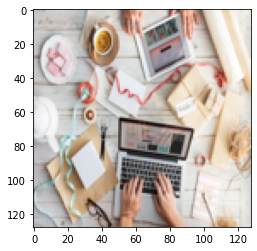

In [ ]:
plt.imshow(inv_norm(valid_imgs["lr"]).permute(1, 2, 0))

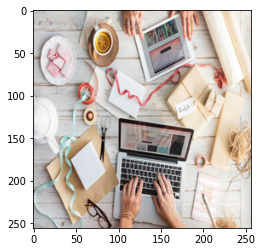

In [ ]:
plt.imshow(inv_norm(valid_imgs["hr"]).permute(1, 2, 0))

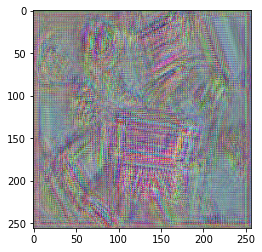

In [ ]:
plt.imshow(inv_norm(output_hr[0]).permute(1, 2, 0).cpu().detach().numpy())

In [ ]:
input_hr = torch.unsqueeze(valid_imgs["hr"], dim=0)
real_label = torch.full([1, 1], 1.0, dtype=input_lr.dtype).to(device)
fake_label = torch.full([1, 1], 0.0, dtype=input_lr.dtype).to(device)
loss_real = adversarial_criterion(discriminator(input_hr.to(device)).clamp(min=0.0, max=1.0), real_label)
loss_fake = adversarial_criterion(discriminator(output_hr).clamp(min=0.0, max=1.0), fake_label)
adv_loss = adversarial_criterion(discriminator(output_hr).clamp(min=0.0, max=1.0), real_label)
print(adv_loss, (loss_real+loss_fake)/2)
# print(discriminator(input_hr.to(device)))
# print(discriminator(output_hr))
# real_label = torch.full([1, 1], 1.0, dtype=input_lr.dtype).to(device)
# fake_label = torch.full([1, 1], 0.0, dtype=input_lr.dtype).to(device)
# print(adversarial_criterion(discriminator(input_hr.to(device)), real_label))
# print(adversarial_criterion(discriminator(output_hr), real_label))

tensor(0.1314, device='cuda:0',
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>) tensor(1.0485, device='cuda:0', grad_fn=<DivBackward0>)


In [ ]:
print(0.5*adversarial_criterion(torch.cat((discriminator(input_hr.to(device)), discriminator(output_hr))), torch.cat((real_label, fake_label))))

tensor(0.0477, device='cuda:0', grad_fn=<MulBackward0>)


In [ ]:
print(content_criterion(vgg_fm(output_hr), vgg_fm(input_hr.to(device))))
print(content_criterion(output_hr, input_hr.to(device)))

tensor(3.1143, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0511, device='cuda:0')


In [ ]:
class ImageDataset2(Dataset):
    def __init__(self, paths, lr_shape, hr_shape):
        self.lr_height, self.lr_width = lr_shape
        self.hr_height, self.hr_width = hr_shape
        # Transforms for low resolution images and high resolution images
        self.lr_transform = transforms.Compose(
            [
                # transforms.Resize((self.lr_height, self.lr_width), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
        self.hr_transform = transforms.Compose(
            [
                # transforms.Resize((self.hr_height, self.hr_width), Image.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ]
        )
        self.paths = ['/content/drive/My Drive/SRGAN/valid/DIV2K_valid_HR/0855.png']

    def __getitem__(self, index):
        path = self.paths[index % len(self.paths)]
        img_hr = Image.open(path)
        img_lr = Image.open("/content/drive/My Drive/SRGAN/valid/DIV2K_valid_LR_unknown/X2/" + path.split('/')[-1].split('.')[0] + "x2.png")
        # five_crop_lr = transforms.FiveCrop((self.lr_height, self.lr_width))
        # five_crop_hr = transforms.FiveCrop((self.hr_height, self.hr_width))
        # imgs_lr = five_crop_lr(img_lr)
        # imgs_hr = five_crop_hr(img_hr)
        # img_idx = np.random.randint(5)
        img_lr = self.lr_transform(img_lr)
        img_hr = self.hr_transform(img_hr)

        return {"lr": img_lr, "hr": img_hr}

    def __len__(self):
        return len(self.paths)

In [ ]:
valid_dataset_path = "/content/drive/My Drive/SRGAN/valid/DIV2K_valid_HR"
valid_paths = glob.glob(valid_dataset_path + "/*.*")
valid_dataset = ImageDataset2(valid_paths, (128, 128), (256, 256))

In [ ]:
# for idx, path in enumerate(valid_dataset.paths):
#     print(idx, path.split('/')[-1].split('.')[0])
#     valid_imgs = valid_dataset[idx]
#     inv_norm = transforms.Normalize((-1,-1,-1),(2,2,2))
#     input_lr = torch.unsqueeze(valid_imgs["lr"], dim=0)
#     with torch.no_grad():
#         output_hr = generator(input_lr.to(device))
#     save_image(inv_norm(output_hr[0]), '/content/drive/My Drive/SRGAN/Outputs/{}.png'.format(path.split('/')[-1].split('.')[0]))

In [ ]:
valid_imgs = valid_dataset[42]
inv_norm = transforms.Normalize((-1,-1,-1),(2,2,2))
# input_lr = torch.unsqueeze(valid_imgs["lr"], dim=0)
# # hr = torch.unsqueeze(lr, dim=0)
# with torch.no_grad():
#     output_hr = generator(input_lr.to(device))

In [ ]:
valid_imgs["hr"].shape

torch.Size([3, 2040, 2040])

In [ ]:
min_len = min(valid_imgs["hr"].shape[1], valid_imgs["hr"].shape[2])//2

In [ ]:
min_len

1020

In [ ]:
report_hr = valid_imgs["hr"]

In [ ]:
report_hr.shape

torch.Size([3, 2040, 2040])

In [ ]:
report_hr[0,640:650,750:1100] = 1.0
report_hr[1,640:650,750:1100] = 0.0
report_hr[2,640:650,750:1100] = 0.0

report_hr[0,1000:1010,750:1100] = 1.0
report_hr[1,1000:1010,750:1100] = 0.0
report_hr[2,1000:1010,750:1100] = 0.0

report_hr[0,640:1010,740:750] = 1.0
report_hr[1,640:1010,740:750] = 0.0
report_hr[2,640:1010,740:750] = 0.0

report_hr[0,640:1010,1100:1110] = 1.0
report_hr[1,640:1010,1100:1110] = 0.0
report_hr[2,640:1010,1100:1110] = 0.0

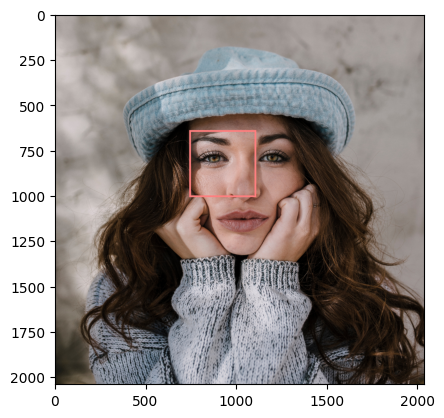

In [ ]:
plt.imshow(inv_norm(report_hr).permute(1, 2, 0))

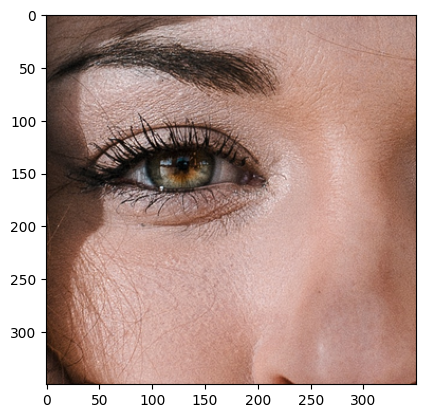

In [ ]:
plt.imshow(inv_norm(report_hr[:,650:1000,750:1100]).permute(1, 2, 0))

In [ ]:
save_image(inv_norm(report_hr), '/content/drive/My Drive/SRGAN/Report/0855_sq.png')

In [ ]:
save_image(inv_norm(report_hr[:,650:1000,750:1100]), '/content/drive/My Drive/SRGAN/Report/0855_HR.png')

0 0855
torch.Size([3, 350, 350]) torch.Size([3, 350, 350])
tensor(0.0597) tensor(24.4767)
1 0855
torch.Size([3, 350, 350]) torch.Size([3, 350, 350])
tensor(0.0564) tensor(24.9674)
2 0855
torch.Size([3, 350, 350]) torch.Size([3, 350, 350])
tensor(0.0605) tensor(24.3579)


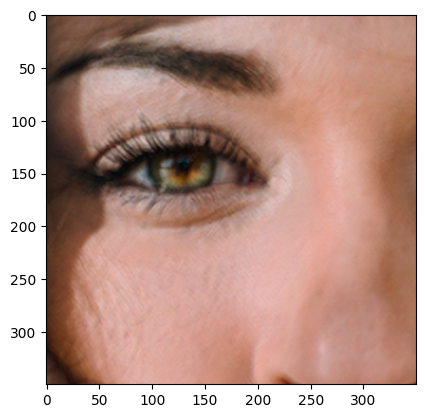

In [ ]:
pres_path = ["/content/drive/My Drive/SRGAN/Outputs/0855.png",
             "/content/drive/My Drive/SRGAN/Outputs2/0855.png",
             "/content/drive/My Drive/SRGAN/Outputs3/0855.png"]
convert_tensor = transforms.ToTensor()
pred_hr = convert_tensor(Image.open('/content/drive/My Drive/SRGAN/Report/0855_HR.png'))
for idx, path in enumerate(pres_path):
    print(idx, path.split('/')[-1].split('.')[0])
    gt_hr = convert_tensor(Image.open(path))
    # gt_hr = gt_hr[:,:,1020-768:1020+768]
    gt_hr = gt_hr[:,650:1000,750:1100]
    print(gt_hr.shape, pred_hr.shape)
    plt.imshow(gt_hr.permute(1, 2, 0))
    save_image(gt_hr, '/content/drive/My Drive/SRGAN/Report/0855_{}.png'.format(idx))
    rmse = torch.sqrt(torch.mean((gt_hr - pred_hr)**2))
    print(rmse, 20 * torch.log10(1.0 / rmse))

In [ ]:
bicubic = torch.nn.functional.interpolate(inv_norm(valid_imgs["lr"]).unsqueeze(0), scale_factor=2, mode="bicubic")
nearest = torch.nn.functional.interpolate(inv_norm(valid_imgs["lr"]).unsqueeze(0), scale_factor=2, mode="nearest")

In [ ]:
save_image(bicubic[0], '/content/drive/My Drive/SRGAN/Report/bicubic.png')
save_image(nearest[0], '/content/drive/My Drive/SRGAN/Report/nearest.png')

In [ ]:
bicubic.shape, nearest.shape

(torch.Size([1, 3, 2040, 1356]), torch.Size([1, 3, 2040, 1356]))

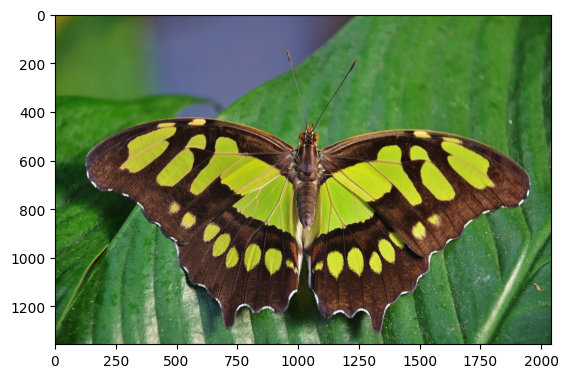

In [ ]:
plt.imshow(inv_norm(valid_imgs["hr"]).permute(1, 2, 0))

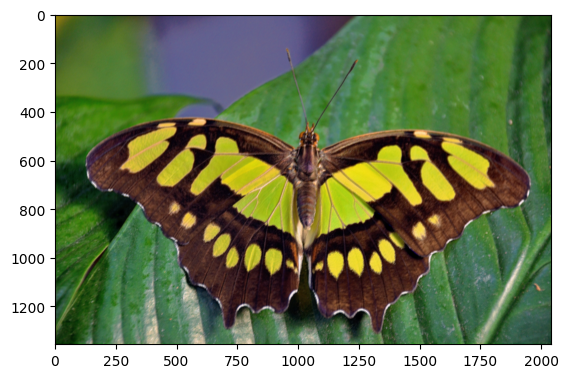

In [ ]:
plt.imshow(inv_norm(output_hr[0]).permute(1, 2, 0).cpu().detach().numpy())

In [ ]:
os.listdir("/content/drive/My Drive/SRGAN/Outputs/")

['0897.png',
 '0887.png',
 '0806.png',
 '0834.png',
 '0896.png',
 '0881.png',
 '0828.png',
 '0833.png',
 '0877.png',
 '0826.png',
 '0879.png',
 '0812.png',
 '0809.png',
 '0865.png',
 '0882.png',
 '0830.png',
 '0892.png',
 '0859.png',
 '0858.png',
 '0816.png',
 '0836.png',
 '0857.png',
 '0824.png',
 '0823.png',
 '0810.png',
 '0900.png',
 '0884.png',
 '0890.png',
 '0835.png',
 '0848.png',
 '0869.png',
 '0878.png',
 '0860.png',
 '0851.png',
 '0870.png',
 '0867.png',
 '0898.png',
 '0818.png',
 '0814.png',
 '0895.png',
 '0856.png',
 '0891.png',
 '0829.png',
 '0825.png',
 '0853.png',
 '0894.png',
 '0863.png',
 '0883.png',
 '0822.png',
 '0837.png',
 '0849.png',
 '0899.png',
 '0807.png',
 '0864.png',
 '0845.png',
 '0871.png',
 '0804.png',
 '0815.png',
 '0813.png',
 '0868.png',
 '0893.png',
 '0876.png',
 '0889.png',
 '0843.png',
 '0862.png',
 '0875.png',
 '0885.png',
 '0866.png',
 '0839.png',
 '0873.png',
 '0820.png',
 '0852.png',
 '0819.png',
 '0808.png',
 '0802.png',
 '0821.png',
 '0811.png',

In [ ]:
pres_path = ["/content/drive/My Drive/SRGAN/Outputs/0807.png",
             "/content/drive/My Drive/SRGAN/Outputs2/0807.png",
             "/content/drive/My Drive/SRGAN/Outputs3/0807.png"]
psnr_mean = 0
rmse_mean = 0
for idx, path in enumerate(pres_path):
    print(idx, path.split('/')[-1].split('.')[0])
    convert_tensor = transforms.ToTensor()
    gt_hr = convert_tensor(Image.open(path))
    pred_hr = convert_tensor(Image.open("/content/drive/My Drive/SRGAN/valid/DIV2K_valid_HR/0842.png"))
    rmse = torch.sqrt(torch.mean((gt_hr - pred_hr)**2))
    print(rmse, 20 * torch.log10(1.0 / rmse))
    psnr_mean += 20 * torch.log10(1.0 / rmse)
    rmse_mean += rmse

psnr_mean = psnr_mean/len(pres_path)
# print(psnr_mean)
rmse_mean = rmse_mean/len(pres_path)
# print(rmse_mean)

0 0842
tensor(0.0483) tensor(26.3276)
1 0842
tensor(0.0451) tensor(26.9129)
2 0842
tensor(0.0473) tensor(26.5076)
3 bicubic
tensor(0.0454) tensor(26.8511)
4 nearest
tensor(0.0467) tensor(26.6201)


In [ ]:
from skimage.metrics import structural_similarity as ssim
import cv2

In [ ]:
pres_path = ["/content/drive/My Drive/SRGAN/Report/0865_0.png",
             "/content/drive/My Drive/SRGAN/Report/0865_1.png",
             "/content/drive/My Drive/SRGAN/Report/0865_2.png"]
ssim_mean = 0
for idx, path in enumerate(pres_path):
    print(idx, path.split('/')[-1].split('.')[0])
    # convert_tensor = transforms.ToTensor()
    gt_hr = cv2.imread(path)
    pred_hr = cv2.imread("/content/drive/My Drive/SRGAN/Report/0865_HR.png")
    print(gt_hr.shape, pred_hr.shape)
    pred_hr = pred_hr/pred_hr.max()
    gt_hr = gt_hr/gt_hr.max()
    # ssim_mean += ssim(gt_hr, pred_hr, data_range=gt_hr.max() - gt_hr.min(), channel_axis=2)
    print(ssim(gt_hr, pred_hr, data_range=gt_hr.max() - gt_hr.min(), channel_axis=2))

ssim_mean = ssim_mean/len(pres_path)
print(ssim_mean)

0 0865_0
(300, 300, 3) (300, 300, 3)
0.6096054253833277
1 0865_1
(300, 300, 3) (300, 300, 3)
0.6234029080300622
2 0865_2
(300, 300, 3) (300, 300, 3)
0.6297482946305973
0.0


In [ ]:
0.6670157169090161

In [ ]:
mse = torch.mean((output_hr[0] - valid_imgs["hr"]) ** 2)
psnr = 10 * torch.log10(1.0 / mse)
print(psnr)

In [ ]:
print(psnr)

tensor(17.0882)


In [ ]:
from torchmetrics import StructuralSimilarityIndexMeasure
ssim = StructuralSimilarityIndexMeasure(data_range=1.0)
ssim(output_hr, torch.unsqueeze(valid_imgs["hr"], dim=0))

tensor(0.2065)

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 9.2 MB/s eta 0:00:00


In [ ]:
save_image(inv_norm(output_hr[0]), '/content/drive/My Drive/SRGAN/Checkpoints/SR.png')
save_image(inv_norm(valid_imgs["hr"]), '/content/drive/My Drive/SRGAN/Checkpoints/GT.png')

In [ ]:
save_image(inv_norm(valid_imgs["lr"]), '/content/drive/My Drive/SRGAN/Checkpoints/LR.png')

In [ ]:
input_hr = torch.unsqueeze(valid_imgs["hr"], dim=0)
print(discriminator(input_hr.to(device)))
print(discriminator(output_hr))
real_label = torch.full([1, 1], 1.0, dtype=input_lr.dtype).to(device)
fake_label = torch.full([1, 1], 0.0, dtype=input_lr.dtype).to(device)
print(adversarial_criterion(discriminator(input_hr.to(device)), real_label))
print(adversarial_criterion(discriminator(output_hr), real_label))